<h1> K -Means Clustering </h1>

In [122]:
# importing req libraries

import numpy as np
import pandas as pd
import seaborn as sns


working on OnlineRetail.csv- this is marketing data, where in we try to segement the customers as in frequently buying shoppers, medium shoppers (based on frequency) OR customer demographics OR customer age etc. <br>

Data- online retail data of 1year 1/12/2010 to 9/12/2010.<br>
Here, we try to identify the customer segments which will be useful for retal store to target the customers accordingly.

Steps for this analysis will be - <br>
1. Read and understand the data.
2. Clean the data
3. Prepare the data for modelling.
4. Modelling
5. Final analysis and business recommendations

# 1. Read and understand the data.

In [123]:
# read the dataset

retail_df = pd.read_csv("Online+Retail.csv",encoding = "ISO-8859-1",sep=",",header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


Invoice No- is same for first 5 items here. This attribute is basically a unique number for each transaction. so it is like for one invoice number different items are ordered. <br>
Customer ID- this attribute can also be seens as same repeating for first 5 items here <br>
Let's check more on attributes 


In [124]:
retail_df.shape

(541909, 8)

In [125]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


# 2. Clean the Data

In [126]:
#handling the missin value in the data

In [127]:
retail_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [128]:
# while handling missing values
# a) if less missing values, remove all the rows.
# b) remove the cols- if cols have lot of missing values

round((retail_df.isnull().sum())/len(retail_df)*100,2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [129]:
# CustomerID has 25% of missing values. We cannot drop this column.
# As customer ID is one of the important column in the data.

#Description has just .27% of missing values.

# hence here, we can just drop those specific rows where we have missing data

In [130]:
#drop all the rows with missing info
retail_df= retail_df.dropna()
retail_df.shape

(406829, 8)

In [131]:
# rechecking the missing% value
round((retail_df.isnull().sum())/len(retail_df)*100,2)

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

# 3. Preparing the data for modelling

In customer segmentation, standard way/basline for using attributes for modelling-
- R (Recency) - how recent is the last trnsaction? ex: Number of days since last purchased

- F (Frequency) - Number of transactions 

- M (Monetary)- Total amount of transaction (revenue contributed)

Based on above there metrics we basically do the clustering.

Numeric attributes in data are- Quantity, derived (number of days since last purchased from date) etc.

In [132]:
# based on "Monetary" metric.
# we can derive the below featured variables i.e new columns

#new column: amount
retail_df['amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [133]:
#groupby customer id in order to check the amount of each.

grouped_df= retail_df.groupby('CustomerID')['amount'].sum() #this returns a series.Hence, do df
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [134]:
# Second derived featured based on "Frequency".

frequency = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID','frequency']
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [135]:
# merging the above new dataframes.

grouped_df = pd.merge(grouped_df, frequency , on ='CustomerID', how='inner')

#inner here will be overlap i.e. common customerid in both dataframes

grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [136]:
# derived variables based on "Recency" 
# example: Number of transactions based on the transaction date column.

#InvoiceDate is of 'object' type . Hence, convert this to datetime
retail_df['InvoiceDate'] = pd.to_datetime(retail_df['InvoiceDate'],format = '%d-%m-%Y %H:%M')

retail_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [137]:
# to compute the recency dervied featured

#intially compute the max invoice date.
# difference between the max and actual invoice date 

max_date = max(retail_df['InvoiceDate'])
print(max_date)

retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head(2)

2011-12-09 12:50:00


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [138]:
# now the recency will the number or count of customerID based on min of diff

last_purchase = retail_df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [139]:
# merging with grouped_df

grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID',how='inner')
grouped_df.columns =['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [140]:
#recency can have only days here.
import datetime as dt

grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


{'whiskers': [<matplotlib.lines.Line2D at 0x22030c2fa60>,
 'caps': [<matplotlib.lines.Line2D at 0x22030c4a1c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x22030c2f6d0>],
 'medians': [<matplotlib.lines.Line2D at 0x22030c4a8e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22030c4ac70>],
 'means': []}

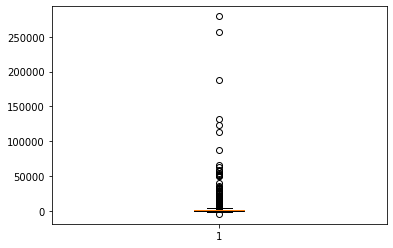

In [141]:
import matplotlib.pyplot as plt
#1. outlier treatment
# by checkling the boxplot
plt.boxplot(grouped_df['amount'])

#there are some data points which seems like outliers


In [142]:
# two types of outliers
# - statistical (aribitrary as in based on IQR etc.)
# - domain specific way 

# treating outliers is based n objective of problem
# like in this case outliers can be clustered under one category
# or for main stream customer analysis we can kind of ignore the ourliers.


{'whiskers': [<matplotlib.lines.Line2D at 0x22030caa040>,
 'caps': [<matplotlib.lines.Line2D at 0x22030caa760>,
 'boxes': [<matplotlib.lines.Line2D at 0x22030c9ac70>],
 'medians': [<matplotlib.lines.Line2D at 0x22030caae80>],
 'fliers': [<matplotlib.lines.Line2D at 0x22030cb7250>],
 'means': []}

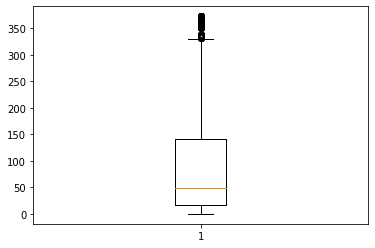

In [143]:
plt.boxplot(grouped_df['recency'])

In [144]:
# ourliers above 300. Since this is for recency it implies that,
# these are customers who did has very less purchasing.
# treatment of outliers here can be either cluestering them in one group
# or deleting them (based on business knowl)

# OUTLIER TRATEMENT USING -IQR

In [145]:
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [146]:
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount>=Q1-1.5*IQR) &
                       (grouped_df.amount<= Q3+1.5*IQR)]
                        
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency>=Q1-1.5*IQR) &
                       (grouped_df.frequency<= Q3+1.5*IQR)]
                        
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency>=Q1-1.5*IQR) &
                       (grouped_df.recency<= Q3+1.5*IQR)]

In [147]:
#2. rescaling as amount, frequency and recency are on diff scales.

rfm_df = grouped_df[['amount','frequency','recency']]

#standard scaler; mean=0;SD=1
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
#fit_tranform
rfm_df_scaled_array = scaler.fit_transform(rfm_df)
rfm_df_scaled_array.shape

(4293, 3)

In [148]:
rfm_df_scaled_array

array([[-0.72373821, -0.75288754,  2.30161144],
       [ 1.73161722,  1.04246665, -0.90646561],
       [ 0.30012791, -0.46363604, -0.18365813],
       ...,
       [-0.67769602, -0.70301659,  0.86589794],
       [-0.6231313 , -0.64317145, -0.84705678],
       [ 0.32293822, -0.07464263, -0.50050524]])

In [149]:
# before this we also need to check if the data is feasible for clusteirng or not
# as in checking for cluster tendency in the data.
# this is done by calc Hopkins Statistic

#if the value is between {0.01,...,0.3} the data is regulary spaced.
#if its 0.5, it is random
#is it is between{0.7,...,0.99} then it has high tendency to cluster

In [150]:
# calculating hopkins statistic

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [151]:
# converting the stardised scaled numpy into dataframe
rfm_df_scaled = pd.DataFrame(rfm_df_scaled_array)
rfm_df_scaled.columns = ['amount','frequency','recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [152]:
#Use the Hopkins Statistic function by passing the above dataframe as a paramter
a= hopkins(rfm_df_scaled)
a

0.9591677911815726

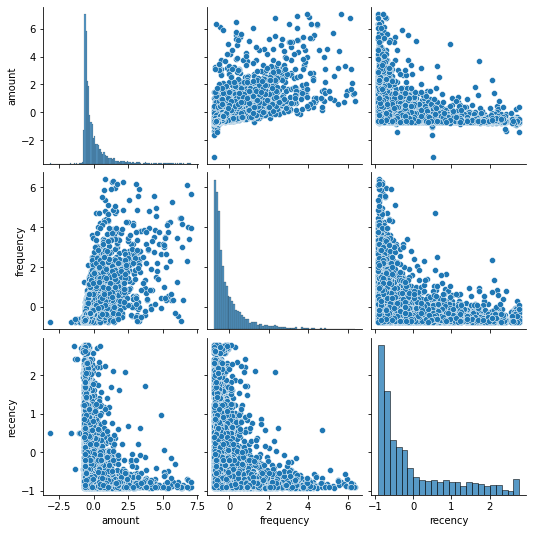

In [153]:
 #visual assessment test
sns.pairplot(rfm_df_scaled)

In [154]:
from pyclustertend import vat, ivat

In [155]:
rfm_df_scaled.head(3)

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658


# 4. Modelling

In [156]:
# importing all the required libraries here
from sklearn.cluster import KMeans

In [157]:
# instantiate the KMeans with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)

#n_clusters= number of clusters
#max_iter= maximum iteration to converge (1.compute distance 2. reassign)
# attributes
#cluster_centers; labels_

kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [158]:
print(kmeans.labels_)
print(len(kmeans.labels_))

[2 1 0 ... 2 0 0]
4293


<h1> optimal clusters - Elbow method </h1>

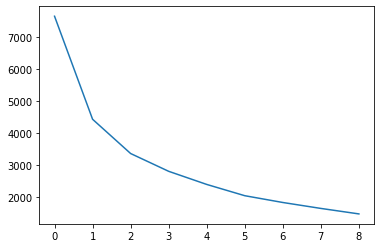

In [159]:
# Since the number of clusters taken in the above step are random,
# now to find the optimum number of clusters, we use two techniques
# 1) Elbow method
# 2) silhouette score

# sometimes number of clusters also depends on business objective/business strategy.

# 1) Elbow curve / sum of squared distance
# we create multiple clusters and then we see the % of information captured in each cluster.
# If adding more clusters doesnt make sense we stop it.
#  a) defind the range of clusters we want to work on 

#inertia is an attibute of SSD of samples to their closest center

ssd =[]
range_n_clusters = [2,3,4,5,6,7,8,9,10]
for num_clusters in range_n_clusters:# do clustersing 
    kmeans = KMeans(n_clusters=num_clusters,max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    

# plot the ssd now for each n clusters
plt.plot(ssd)

#x axis => number of clusters as defined above.

In grapgh, 2 clusters ssd=9000, and after some point SSD decreases much less gradually.
In the above figure after some point(3-4), adding anymore clusters doesnt decrease the value of SSD significatnly.
SSD = sum of squred distance of individual samples to their closest cluster center.
The rate of drop after cluster 3 (that is 1 in graph) is significant.

<h1> Optimal clusters- Silhouette Analysis </h1>

Imagine there are 2 clusters say C1,C2 and consider one data point p1 in C1, we call two clusters to be good if this p1 is as far away as from C2 (inter cluster distance should be high) and p1 in C1 should be low (intra cluster distance is low). This is encapsulated in the silhouette analysis.

<b> silhoutter score = p-q/ max(p,q) </b>

p- mean distance to all the points in the nearest cluster that data point is not part of (intercluster distance)

q-mean intra-cluster distance to all the points in its own cluster

1) value of silhouette score ranges between -1 to 1 <br>
2) score closer to 1 indicated that data point is very simila to other data points in the cluster. <br>
3) -1 indicated that data point is not similar to the data points in its cluster.


In [160]:
# p1 = 15 in C1
# p = 10 dist(p1,C2)
# q = 12
# silhoutter score= -2/12 = -1/6 
#- negative score indicates poor clustering as its closer to nearby cluster C2 than its own cluster c1

In [161]:
# silhoutte analysis

from sklearn.metrics import silhouette_score

range_n_clusters = [2,3,4,5,6,7,8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    silhoutter_avg = silhouette_score(rfm_df_scaled,cluster_labels)
    print("for n_clusters={0}, the silhoutte score is {1}".format(num_clusters,silhoutter_avg))

for n_clusters=2, the silhoutte score is 0.5415858652525395
for n_clusters=3, the silhoutte score is 0.5084896296141937
for n_clusters=4, the silhoutte score is 0.48161393329059127
for n_clusters=5, the silhoutte score is 0.4668853500035996
for n_clusters=6, the silhoutte score is 0.41758431193450735
for n_clusters=7, the silhoutte score is 0.41481670613813887
for n_clusters=8, the silhoutte score is 0.4098982645228885


In [162]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)


KMeans(max_iter=50, n_clusters=3)

In [163]:
kmeans.labels_

array([1, 2, 0, ..., 1, 0, 0])

In [164]:
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


<AxesSubplot:xlabel='cluster_id', ylabel='amount'>

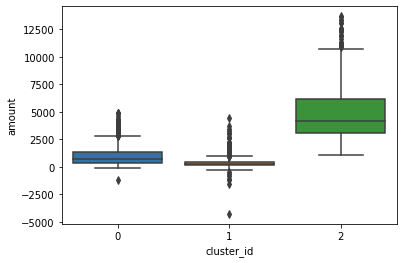

In [165]:
# we have done clustering using 3 features, now lets just check the average of each.

# plot- to see the  disrtibution of numeric variables

import seaborn as sns
sns.boxplot(y='amount',x='cluster_id',data=grouped_df)

amount varies much lesser in cluster 2 represents high values customers,
and cluster 0 as average values customers

<AxesSubplot:xlabel='cluster_id', ylabel='recency'>

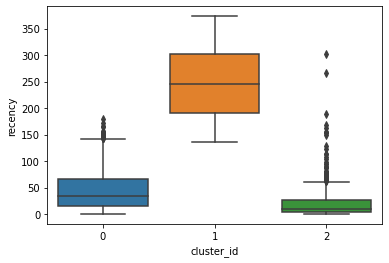

In [166]:
sns.boxplot(y='recency',x='cluster_id',data=grouped_df)

<AxesSubplot:xlabel='cluster_id', ylabel='frequency'>

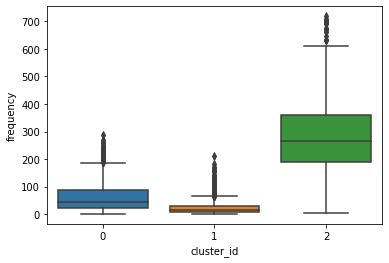

In [167]:
sns.boxplot(y='frequency',x='cluster_id',data=grouped_df)

Before outlier treatement- 
As we can see above clusters basically vary very high this might be due to the outliers in one of the cluster compared to other.
These needs to sorted based on domain knowlege. Sorted how? by doing the ourlier analysis. Now rolling back to the prior steps to do the outlier analysis

after outlier treatment:
We can that cluster 2 represents the customers who buys things frequently

In [168]:
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount>=Q1-1.5*IQR) &
                       (grouped_df.amount<= Q3+1.5*IQR)]
                       
